# Proyecto 1 Reconocimiento de Patrones

José Julián Camacho Hernández

Leonardo Guillén Fernández

## Regresión Logística

In [249]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score


In [250]:
accuracy_data_ = []
precision_data = []
recall_data = []
auc_data = []
f1_data = []

accuracy_sklearn = []
precision_sklearn = []
recall_sklearn = []
auc_sklearn = []
f1_sklearn = []

In [3]:
class Logistic_Regression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
       

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # weights initialization
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h-y)) / y.size
            #print(gradient.shape, self.w.shape, z.shape,h.shape)
            #gradient = (h - y) / y.size
            self.w -= self.lr * gradient

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold
    def score(self, y_pred,y_test):
        return float(sum(y_pred == y_test)) / float(len(y_test))


In [4]:
def detect_outliers(data):
    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = [x for x in data if x < lower_bound or x > upper_bound]

    return outliers

### Set de datos Red Wine Quality

In [234]:
# Cargar los datos de Red Wine Quality
data_wines = pd.read_csv("winequality-red.csv")

#======  Feature Engineering  ======#

# Convertir la calidad en un problema de clasificación binaria
data_wines['quality'] = np.where(data_wines['quality'] > 5, 1, 0)  

# Eliminar datos outliers según el rango intercuartílico
print(data_wines.shape)
Q1 = data_wines.quantile(0.25)
Q3 = data_wines.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = ((data_wines < (Q1 - 1.5 * IQR)) | (data_wines > (Q3 + 1.5 * IQR))).any(axis=1)
data_wines = data_wines[~outlier_mask]
print(data_wines.shape)

# Estandarización de los datos
X = data_wines.drop('quality', axis=1)
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
scaler.fit(X[numeric_cols])
scaled_data = scaler.transform(X[numeric_cols])
data_wines[numeric_cols] = scaled_data

#data_wines = data_wines.drop('volatile acidity', axis=1)
#data_wines = data_wines.drop('fixed acidity', axis=1)
data_wines = data_wines.drop('density', axis=1)
data_wines = data_wines.drop('total sulfur dioxide', axis=1)
#data_wines = data_wines.drop('sulphates', axis=1)
#data_wines = data_wines.drop('pH', axis=1)


# Dividir los datos en conjunto de entrenamiento y prueba
X_train_wines, X_test_wines, y_train_wines, y_test_wines = train_test_split(data_wines.drop('quality', axis=1), 
    data_wines['quality'], test_size=0.2, stratify=data_wines['quality'])

X_train_train_wines = X_train_wines
X_train_wines = X_train_wines.values
X_test_test_wines = X_test_wines
X_test_wines  = X_test_wines.values
y_train_wines = y_train_wines.values
y_test_wines  = y_test_wines.values

data_wines.head(3)

(1599, 12)
(1194, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,pH,sulphates,alcohol,quality
0,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,1.408196,-0.621576,-0.989805,0
1,-0.250994,2.167738,-1.377452,0.937243,1.365747,1.133715,-0.938945,0.411596,-0.579638,0
2,-0.250994,1.439628,-1.155393,0.258471,0.946004,-0.000665,-0.484660,0.153303,-0.579638,0


In [62]:
def computeMetrics(y_test, y_pred):
    # Calcular la exactitud
    acc = accuracy_score(y_test, y_pred)
    accuracy_data_.append(acc)

    # Calcular la precisión
    prec = precision_score(y_test, y_pred)
    precision_data.append(prec)

    # Calcular el recall
    rec = recall_score(y_test, y_pred)
    recall_data.append(rec)

    # Calcular F1 score
    f1 = f1_score(y_test, y_pred) 
    f1_data.append(f1)
    
    # Calcular el AUC
    auc = roc_auc_score(y_test, y_pred)
    auc_data.append(auc)

    # Desplegar métricas
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "AUC":auc}
    df = pd.DataFrame(metrics, index = [0])
    display(df)

    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred) # Compute the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve and AUC')
    plt.legend(loc="lower right")
    plt.show()

Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.741361,0.769539,0.744186,0.75665,0.741114


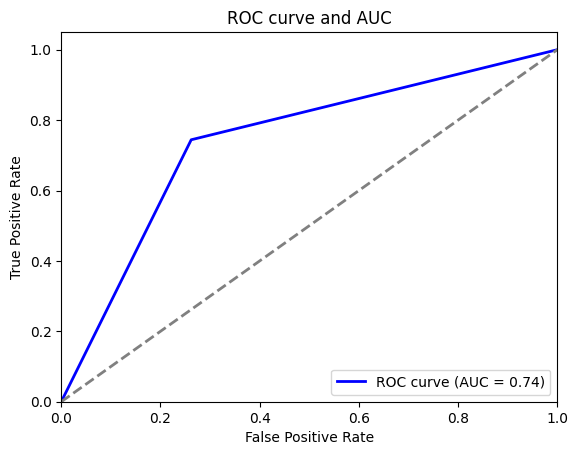

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.753138,0.791667,0.736434,0.763052,0.754581


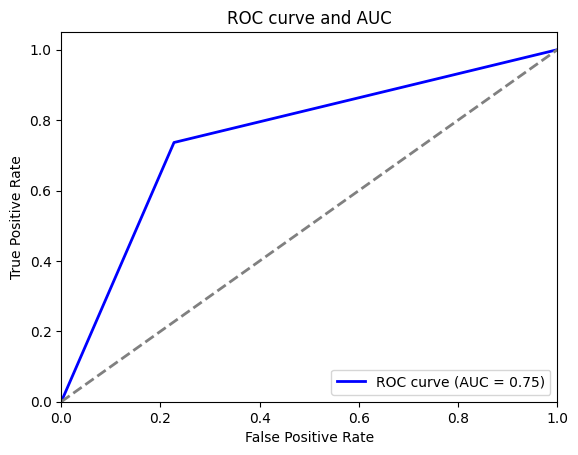

In [251]:
# Entrenar el modelo de regresión logística
logistic_reg_model = Logistic_Regression(lr=0.03, num_iter=50000)
logistic_reg_model.fit(X_train_wines, y_train_wines)

# Realizar predicciones sobre los datos de training
y_pred_wines_train = logistic_reg_model.predict(X_train_wines, 0.5)
# Realizar predicciones sobre los datos de testing
y_pred_wines_test = logistic_reg_model.predict(X_test_wines, 0.5)

#print("Resultados obtenidos: ", y_pred_wines[:20])
#print("Resultados esperados: ", y_test_wines[:20], "\n")

print("Resultados para el conjunto de training")
display(computeMetrics(y_train_wines, y_pred_wines_train))

print("Resultados para el conjunto de testing")
computeMetrics(y_test_wines, y_pred_wines_test)

### Set de datos Notas de Arquitectura de Computadores 1

In [150]:
# Cargar los datos de Arquitectura 1
data_arquiI_2021_s1 = pd.read_csv("2021-s1.csv", delimiter=';')
data_arquiI_2021_s2 = pd.read_csv("2021-s2.csv", delimiter=';')
data_arquiI_2022_s1 = pd.read_csv("2022-s1.csv", delimiter=';')
data_arquiI_2022_s2 = pd.read_csv("2022-s2.csv", delimiter=';')

#=======  Feature Engineering  =======#

# Feature Selection
# Conservar solo features que se toman en cuenta de cada archivo
data_arquiI_2021_s1 = data_arquiI_2021_s1.loc[:, ['Examen 1 15.0%', 'Tarea 1 3.75%',
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Funcional 13.12%', 'Total: ']]
data_arquiI_2021_s2 = data_arquiI_2021_s2.loc[:, ['Examen 1 15.0%', 'Tarea 1', 
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Funcional 13.12%', 'Total: ']]
data_arquiI_2022_s1 = data_arquiI_2022_s1.loc[:, ['Examen parcial 1 15%', 'Tarea 1 evaluación 3.75%',
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Funcional 13.12%', 'Total: ']]
data_arquiI_2022_s2 = data_arquiI_2022_s2.loc[:, ['Examen parcial 1 15%', 'Tarea 1 3.75%',
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Func Eval 13.12%', 'Total: ']]

# Renombrar columnas para combinarlas
data_arquiI_2021_s1 = data_arquiI_2021_s1.rename(columns={'Examen parcial 1 15%': 'Examen 1 15.0%'})
data_arquiI_2021_s2 = data_arquiI_2021_s2.rename(columns={'Tarea 1': 'Tarea 1 3.75%'})
data_arquiI_2022_s1 = data_arquiI_2022_s1.rename(columns={'Examen parcial 1 15%': 'Examen 1 15.0%', 
                            'Tarea 1 evaluación 3.75%': 'Tarea 1 3.75%'})
data_arquiI_2022_s2 = data_arquiI_2022_s2.rename(columns={'Examen parcial 1 15%': 'Examen 1 15.0%', 
                            'Proyecto Grupal 1 Func Eval 13.12%': 'Proyecto Grupal 1 Funcional 13.12%'})

# Combinar todos los datos en un solo set
data_arquiI_combined = pd.concat([data_arquiI_2021_s1, data_arquiI_2021_s2,
                                  data_arquiI_2022_s1, data_arquiI_2022_s2], 
                                  axis=0, ignore_index=True)

# Reemplazar espacios en blanco con NaN
data_arquiI_combined = data_arquiI_combined.replace(' ', np.nan)
# Eliminar filas que contengan al menos un NaN
data_arquiI_combined = data_arquiI_combined.dropna()
# Castear tipos de string a float
data_arquiI_combined = data_arquiI_combined.astype('float64')


# Convertir la calidad en un problema de clasificación binaria
data_arquiI_combined['Total: '] = np.where(data_arquiI_combined['Total: '] >= 67.5, 1, 0)

# Ajustar pesos
data_arquiI_combined['Examen 1 15.0%'] = data_arquiI_combined['Examen 1 15.0%']*0.15
data_arquiI_combined['Tarea 1 3.75%'] = data_arquiI_combined['Tarea 1 3.75%']*0.0375
data_arquiI_combined['Proyecto Individual Funcional 11.25%'] = data_arquiI_combined['Proyecto Individual Funcional 11.25%']*0.1125
data_arquiI_combined['Proyecto Grupal 1 Funcional 13.12%'] = data_arquiI_combined['Proyecto Grupal 1 Funcional 13.12%']*0.1312

data_arquiI_combined = data_arquiI_combined.rename(columns={'Total: ': 'Aprobado'})

# Estandarización de los datos
#X = data_arquiI_combined.drop('Aprobado', axis=1)
#numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
#scaler = StandardScaler()
#scaler.fit(X[numeric_cols])
#scaled_data = scaler.transform(X[numeric_cols])
#data_arquiI_combined[numeric_cols] = scaled_data
#data_arquiI_combined.head(50)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_arqui, X_test_arqui, y_train_arqui, y_test_arqui = train_test_split(data_arquiI_combined.drop('Aprobado', axis=1), 
    data_arquiI_combined['Aprobado'], test_size=0.2, stratify=data_arquiI_combined['Aprobado'])

X_train_train_arqui = X_train_arqui
X_train_arqui = X_train_arqui.values
X_test_test_arqui = X_test_arqui
X_test_arqui  = X_test_arqui.values
y_train_arqui = y_train_arqui.values
y_test_arqui  = y_test_arqui.values

data_arquiI_combined.head(3)

,Examen 1 15.0%,Tarea 1 3.75%,Proyecto Individual Funcional 11.25%,Proyecto Grupal 1 Funcional 13.12%,Aprobado
0,7.995,2.85000,11.25,13.120,1
2,7.440,3.75000,11.25,5.904,1
4,9.240,2.50125,11.25,13.120,1


Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.926471,0.932203,0.982143,0.956522,0.824405


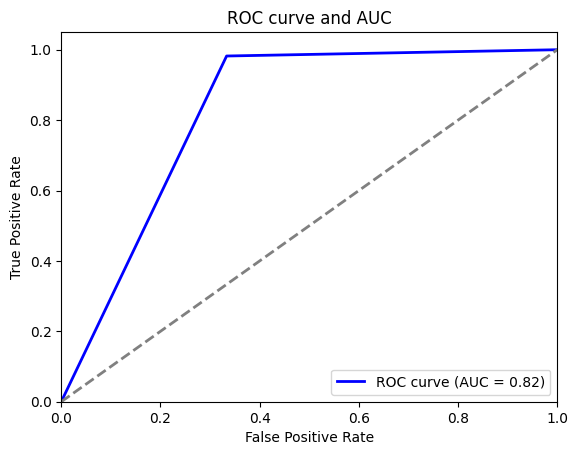

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.944444,0.9375,1.0,0.967742,0.833333


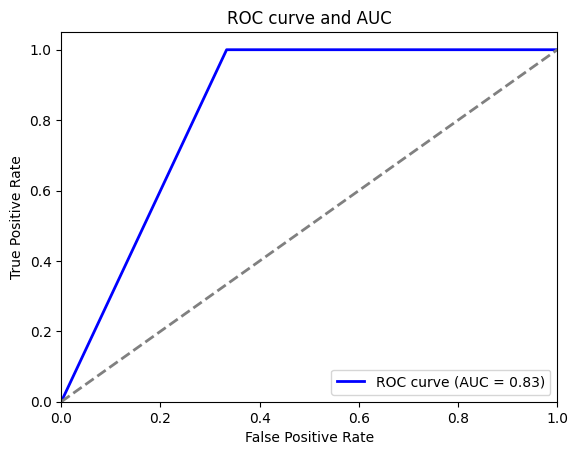

In [252]:
# Entrenar el modelo de regresión logística
logistic_reg_model = Logistic_Regression(lr=0.03, num_iter=50000)
logistic_reg_model.fit(X_train_arqui, y_train_arqui)

# Realizar predicciones sobre los datos de training
y_pred_arqui_train = logistic_reg_model.predict(X_train_arqui, 0.5)
# Realizar predicciones sobre los datos de testing
y_pred_arqui_test = logistic_reg_model.predict(X_test_arqui, 0.5)

#print("Resultados obtenidos: ", y_pred_arqui[:20])
#print("Resultados esperados: ", y_test_arqui[:20], "\n")

print("Resultados para el conjunto de training")
display(computeMetrics(y_train_arqui, y_pred_arqui_train))

print("Resultados para el conjunto de testing")
computeMetrics(y_test_arqui, y_pred_arqui_test)

### Set de datos Propio

In [152]:
# Cargar los datos de Red Wine Quality
data_heart = pd.read_csv("heart.csv")

#======  Feature Engineering  ======#

# Eliminar datos outliers según el rango intercuartílico
print(data_heart.shape)
Q1 = data_heart.quantile(0.25)
Q3 = data_heart.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = ((data_heart < (Q1 - 1.5 * IQR)) | (data_heart > (Q3 + 1.5 * IQR))).any(axis=1)
data_heart = data_heart[~outlier_mask]
print(data_heart.shape)

## Estandarización de los datos
X = data_heart.drop(['target', 'sex', 'fbs', 'exang'], axis=1)
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler.fit(X[numeric_cols])
scaled_data = scaler.transform(X[numeric_cols])
data_heart[numeric_cols] = scaled_data
#data_heart = data_heart.drop('volatile acidity', axis=1)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(data_heart.drop('target', axis=1), 
    data_heart['target'], test_size=0.2, stratify=data_heart['target'])

X_train_train_heart = X_train_heart
X_train_heart = X_train_heart.values
X_test_test_heart = X_test_heart
X_test_heart  = X_test_heart.values
y_train_heart = y_train_heart.values
y_test_heart  = y_test_heart.values

data_heart.head(3)

(303, 14)
(228, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1,0.170213,1,0.666667,0.473684,0.519651,0,0.5,0.868421,0,0.875,0.0,0.0,0.5,1
2,0.255319,0,0.333333,0.473684,0.318777,0,0.0,0.736842,0,0.350,1.0,0.0,0.5,1
3,0.574468,1,0.333333,0.342105,0.458515,0,0.5,0.789474,0,0.200,1.0,0.0,0.5,1


Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.851648,0.848214,0.904762,0.875576,0.841991


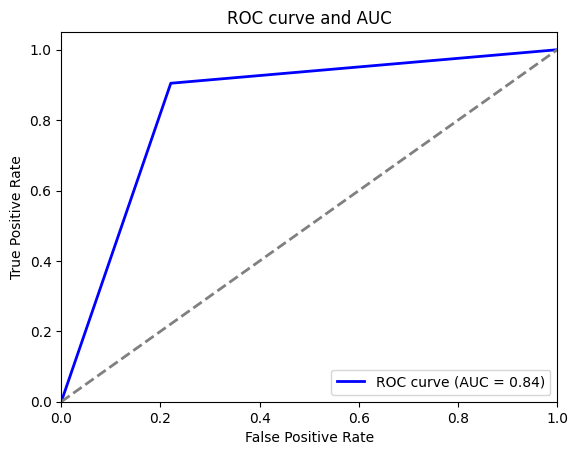

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.913043,0.96,0.888889,0.923077,0.918129


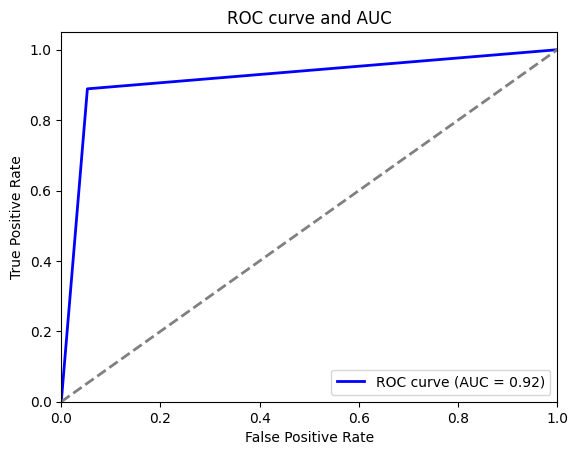

In [253]:
# Entrenar el modelo de regresión logística
logistic_reg_model = Logistic_Regression(lr=0.03, num_iter=50000)
logistic_reg_model.fit(X_train_heart, y_train_heart)

# Realizar predicciones sobre los datos de training
y_pred_heart_train = logistic_reg_model.predict(X_train_heart, 0.5)
# Realizar predicciones sobre los datos de testing
y_pred_heart_test = logistic_reg_model.predict(X_test_heart, 0.5)

#print("Resultados obtenidos: ", y_pred_heart[:20])
#print("Resultados esperados: ", y_test_heart[:20], "\n")

print("Resultados para el conjunto de training")
display(computeMetrics(y_train_heart, y_pred_heart_train))

print("Resultados para el conjunto de testing")
computeMetrics(y_test_heart, y_pred_heart_test)

## Árboles de decisión

In [36]:
class DecisionTree:
    def __init__(self):
        self.tree = None

    def split_data(self, data, split_column, split_value):
        data_below = data[data[split_column] <= split_value]
        data_above = data[data[split_column] > split_value]
        return data_below, data_above

    def entropy(self, data, target_column):
        _, counts = np.unique(data[target_column], return_counts=True)
        probabilities = counts / counts.sum()
        entropy = sum(probabilities * -np.log2(probabilities))
        return entropy

    def information_gain(self, data, split_column, target_column):
        original_entropy = self.entropy(data, target_column)
        data_below, data_above = self.split_data(data, split_column, data[split_column].median())
        n = len(data)
        n_below = len(data_below)
        n_above = len(data_above)
        below_weight = n_below / n
        above_weight = n_above / n
        weighted_entropy = below_weight * self.entropy(data_below, target_column) + above_weight * self.entropy(data_above, target_column)
        information_gain = original_entropy - weighted_entropy
        return information_gain

    def find_best_split(self, data, target_column):
        information_gains = []
        for column in data.columns:
            if column == target_column:
                continue
            information_gain1 = self.information_gain(data, column, target_column)
            information_gains.append((column, information_gain1))
        best_split_column, best_information_gain = max(information_gains, key=lambda x: x[1])
        return best_split_column

    def create_decision_node(self, data, target_column):
        if len(np.unique(data[target_column])) == 1:
            return data[target_column].iloc[0]
        if len(data.columns) == 1:
            return np.bincount(data[target_column]).argmax()
        best_split_column = self.find_best_split(data, target_column)
        decision_node = {'split_column': best_split_column}
        median = data[best_split_column].median()
        decision_node['median'] = median
        data_below, data_above = self.split_data(data, best_split_column, median)
        decision_node['below'] = self.create_decision_node(data_below, target_column)
        decision_node['above'] = self.create_decision_node(data_above, target_column)
        return decision_node

    def predict(self, example, decision_tree):
        if type(decision_tree) != dict:
            return decision_tree
        split_column = decision_tree['split_column']
        median = decision_tree['median']
        if example[split_column] <= median:
            return self.predict(example, decision_tree['below'])
        else:
            return self.predict(example, decision_tree['above'])

            


### Set de datos Red Wine Quality

Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


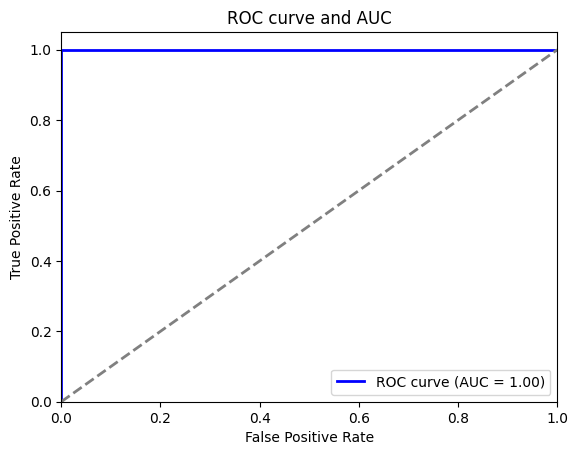

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


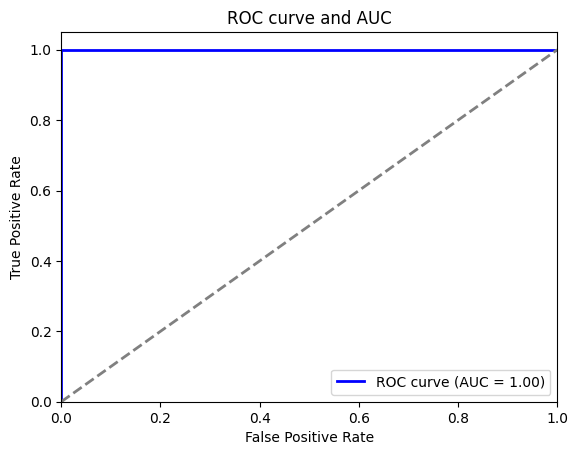

In [254]:
#Instanciar modelo de árbol de decision
# Crear el árbol de decisión a partir del conjunto de entrenamiento
decision_tree = DecisionTree()
nodes = decision_tree.create_decision_node(data_wines, 'quality')

# Evaluar el árbol de decisión en el conjunto de training
y_pred_wines_train = X_train_train_wines.apply(lambda x: decision_tree.predict(x, nodes), axis=1)
# Evaluar el árbol de decisión en el conjunto de testing
y_pred_wines_test = X_test_test_wines.apply(lambda x: decision_tree.predict(x, nodes), axis=1)

#print("Resultados obtenidos: ", y_pred_wines[:20])
#print("Resultados esperados: ", y_test_wines[:20], "\n")

print("Resultados para el conjunto de training")
display(computeMetrics(y_train_wines, y_pred_wines_train))

print("Resultados para el conjunto de testing")
computeMetrics(y_test_wines, y_pred_wines_test)

### Set de datos Notas de Arquitectura de Computadores 1

Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


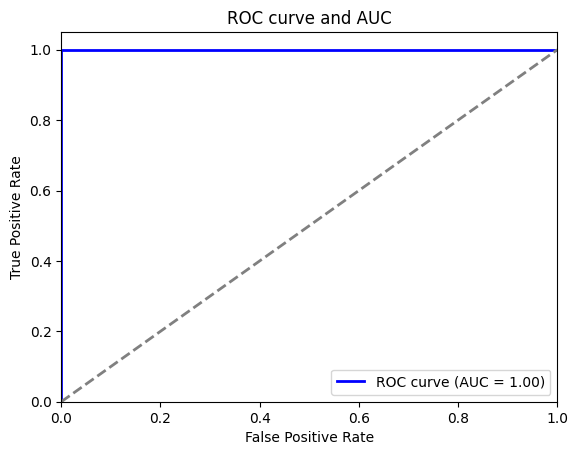

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


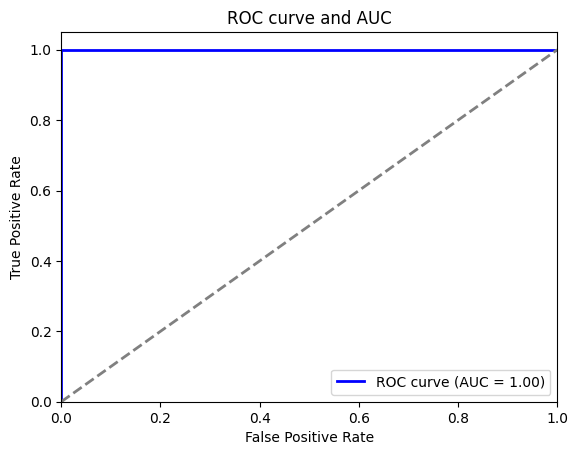

In [255]:
#Instanciar modelo de árbol de decision
# Crear el árbol de decisión a partir del conjunto de entrenamiento
decision_tree =  DecisionTree()
nodes = decision_tree.create_decision_node(data_arquiI_combined, 'Aprobado')

# Evaluar el árbol de decisión en el conjunto de training
y_pred_arqui_train = X_train_train_arqui.apply(lambda x: decision_tree.predict(x, nodes), axis=1)
# Evaluar el árbol de decisión en el conjunto de testing
y_pred_arqui_test = X_test_test_arqui.apply(lambda x: decision_tree.predict(x, nodes), axis=1)

#print("Resultados obtenidos: ", y_pred_arqui[:20])
#print("Resultados esperados: ", y_test_arqui[:20], "\n")

print("Resultados para el conjunto de training")
display(computeMetrics(y_train_arqui, y_pred_arqui_train))

print("Resultados para el conjunto de testing")
computeMetrics(y_test_arqui, y_pred_arqui_test)

### Set de datos Propio

Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


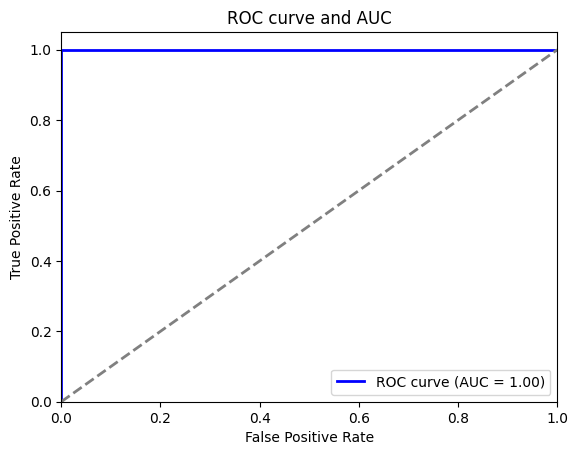

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


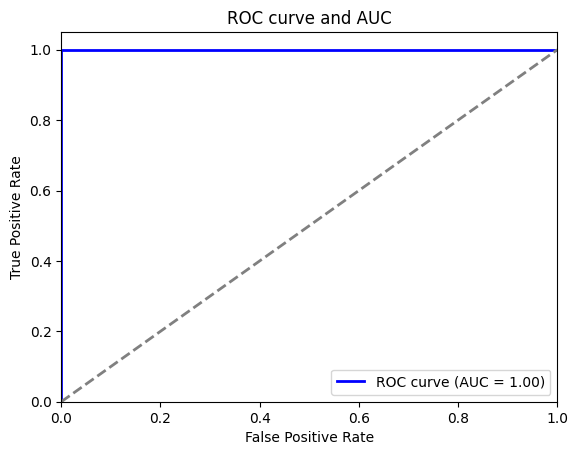

In [256]:
#Instanciar modelo de árbol de decision
# Crear el árbol de decisión a partir del conjunto de entrenamiento
decision_tree = DecisionTree()
nodes = decision_tree.create_decision_node(data_heart, 'target')

# Evaluar el árbol de decisión en el conjunto de training
y_pred_heart_train = X_train_train_heart.apply(lambda x: decision_tree.predict(x, nodes), axis=1)
# Evaluar el árbol de decisión en el conjunto de testing
y_pred_heart_test = X_test_test_heart.apply(lambda x: decision_tree.predict(x, nodes), axis=1)

#print("Resultados obtenidos: ", y_pred_heart[:20])
#print("Resultados esperados: ", y_test_heart[:20], "\n")

print("Resultados para el conjunto de training")
display(computeMetrics(y_train_heart, y_pred_heart_train))

print("Resultados para el conjunto de testing")
computeMetrics(y_test_heart, y_pred_heart_test)

## KNN

In [46]:
class KNearestNeighbors():
    def __init__(self, X_train, y_train, n_neighbors=5, weights='uniform'):

        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights

        self.n_classes = 2

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []

        #print(X_test, self.X_train. X_test, self.X_train)
        point_dist = []
        for x_test in X_test:
            point_dist += [ self.euclidian_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]
            #print("Sorted_neighs: ", sorted_neigh)
            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)

    def predict(self, X_test):

        if self.weights == 'uniform':
            neighbors = self.kneighbors(X_test)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])
            #print("Y_pred: ", y_pred)
            return y_pred

        if self.weights == 'distance':

            dist, neigh_ind = self.kneighbors(X_test, return_distance=True) #Obtener distancias y vecinos
            neighbors = []
            neighbors = [self.y_train[i] for i in neigh_ind] #Obtener los tipos segun los indices de vecinos
            
            y_pred = []
            for i in range(len(neighbors)):
                distances = {}                              #Diccionario para guardar distancias por tipo
                for j in range(len(neighbors[i])):
                    neighbor_type = neighbors[i][j]         #Obtener tipo de vecino
                    distance = dist[i][j]                   #Obtener distancia a dicho vecino
                    if neighbor_type in distances:          #Guardar en el diccionario
                        distances[neighbor_type].append(distance)
                    else:
                        distances[neighbor_type] = [distance]
                
                average_distances = {}                      #Diccionario para guardar promedio de distancias
                for neighbor_type in distances:
                    average_distance = np.mean(distances[neighbor_type])
                    average_distances[neighbor_type] = average_distance

                #Obtener minima distancia promedio 
                min_distance_type = min(average_distances, key=average_distances.get)
                #print("El tipo {} tiene la mínima distacia promedio y es: {}".format(min_distance_type, average_distances[min_distance_type]))
                y_pred.append(min_distance_type)

            return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return float(sum(y_pred == y_test)) / float(len(y_test)), y_pred, y_test


### Set de datos Red Wine Quality

Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.815707,0.823194,0.839147,0.831094,0.813651


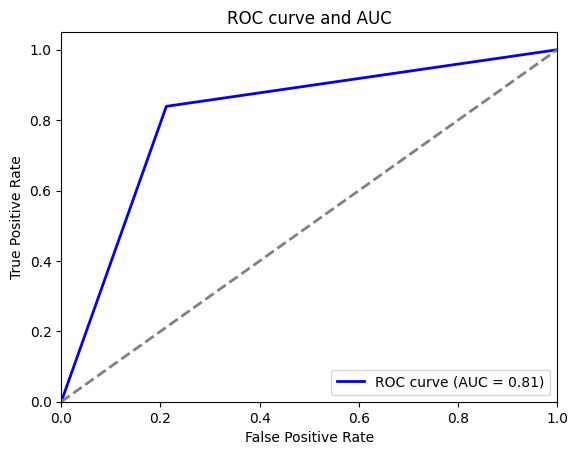

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.728033,0.738806,0.767442,0.752852,0.72463


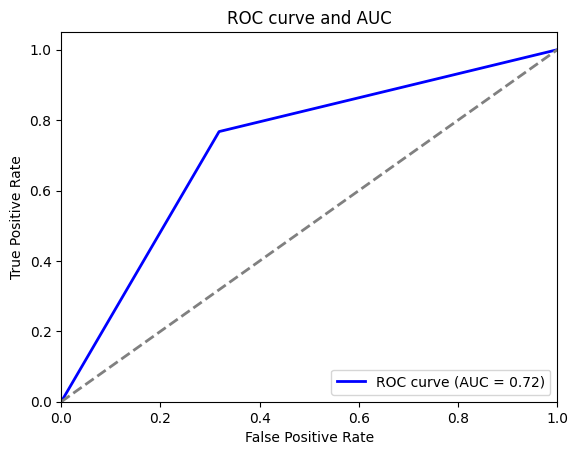

In [257]:
#Instanciar clasificador
classifier = KNearestNeighbors(X_train_wines, y_train_wines, n_neighbors=5, weights='uniform')

# Realizar predicciones sobre los datos de training
y_pred_wines_train = classifier.predict(X_train_wines)
# Realizar predicciones sobre los datos de testing
y_pred_wines_test = classifier.predict(X_test_wines)

#print("Resultados obtenidos: ", y_pred_wines[:20])
#print("Resultados esperados: ", y_test_wines[:20], "\n")

print("Resultados para el conjunto de training")
display(computeMetrics(y_train_wines, y_pred_wines_train))

print("Resultados para el conjunto de testing")
computeMetrics(y_test_wines, y_pred_wines_test)

### Set de datos Notas de Arquitectura de Computadores 1

Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.926471,0.932203,0.982143,0.956522,0.824405


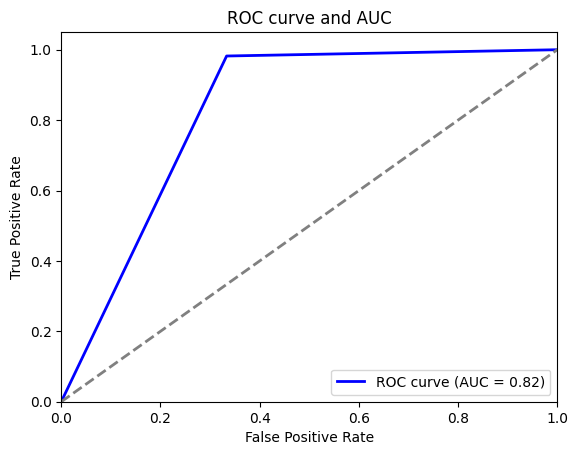

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


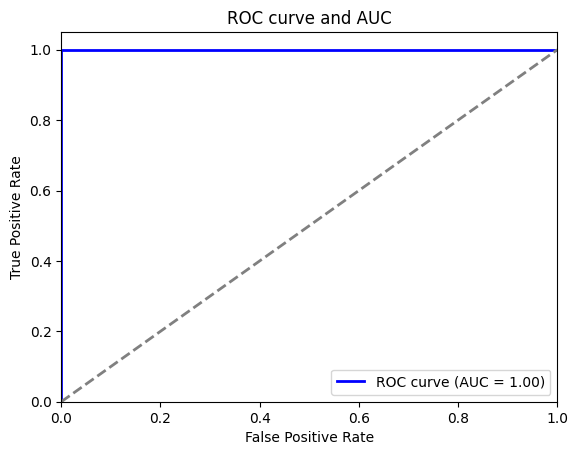

In [258]:
#Instanciar clasificador
classifier = KNearestNeighbors(X_train_arqui, y_train_arqui, n_neighbors=3, weights='uniform')

# Realizar predicciones sobre los datos de training
y_pred_arqui_train = classifier.predict(X_train_arqui)
# Realizar predicciones sobre los datos de testing
y_pred_arqui_test = classifier.predict(X_test_arqui)

#print("Resultados obtenidos: ", y_pred_arqui[:20])
#print("Resultados esperados: ", y_test_arqui[:20], "\n")

print("Resultados para el conjunto de training")
display(computeMetrics(y_train_arqui, y_pred_arqui_train))

print("Resultados para el conjunto de testing")
computeMetrics(y_test_arqui, y_pred_arqui_test)

### Set de datos Propio

Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.840659,0.839286,0.895238,0.866359,0.830736


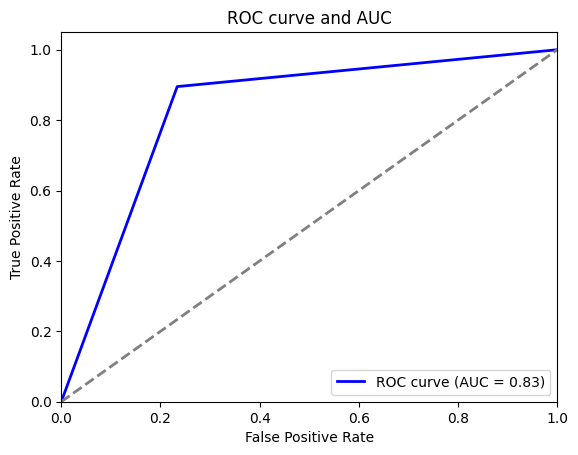

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.826087,0.88,0.814815,0.846154,0.82846


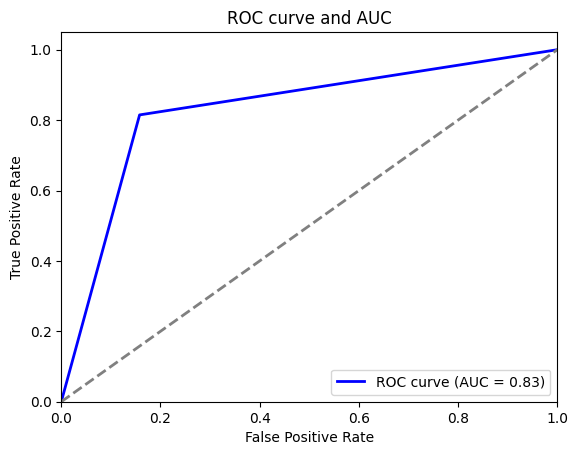

In [259]:
#Instanciar clasificador
classifier = KNearestNeighbors(X_train_heart, y_train_heart, n_neighbors=7, weights='uniform')

# Realizar predicciones sobre los datos de training
y_pred_heart_train = classifier.predict(X_train_heart)
# Realizar predicciones sobre los datos de testing
y_pred_heart_test = classifier.predict(X_test_heart)

#print("Resultados obtenidos: ", y_pred_heart[:20])
#print("Resultados esperados: ", y_test_heart[:20], "\n")

print("Resultados para el conjunto de training")
display(computeMetrics(y_train_heart, y_pred_heart_train))

print("Resultados para el conjunto de testing")
computeMetrics(y_test_heart, y_pred_heart_test)

## Comparación con sklearn

### Regresión Logística Red Wine Quality Sklearn

In [226]:
def computeSklearnMetrics(y_test, y_pred):
    # Calcular la exactitud
    acc = accuracy_score(y_test, y_pred)
    accuracy_sklearn.append(acc)

    # Calcular la precisión
    prec = precision_score(y_test, y_pred)
    precision_sklearn.append(prec)

    # Calcular el recall
    rec = recall_score(y_test, y_pred)
    recall_sklearn.append(rec)

    # Calcular F1 score
    f1 = f1_score(y_test, y_pred) 
    f1_sklearn.append(f1)

    # Calcular el AUC
    auc = roc_auc_score(y_test, y_pred)
    auc_sklearn.append(auc)

    # Desplegar métricas
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "AUC":auc}
    df = pd.DataFrame(metrics, index = [0])
    display(df)
    
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred) # Compute the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve and AUC')
    plt.legend(loc="lower right")
    plt.show()

Los mejores parámetros son:  {'max_iter': 5}
Precisión del algoritmo: 0.74
Resultados para el conjunto de training


/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

,Accuracy,Precision,Recall,F1 Score,AUC
0,0.740314,0.768,0.744186,0.755906,0.739975


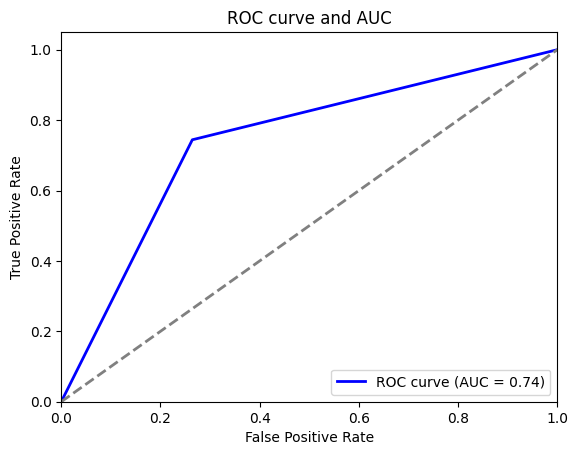

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.74477,0.783333,0.728682,0.75502,0.746159


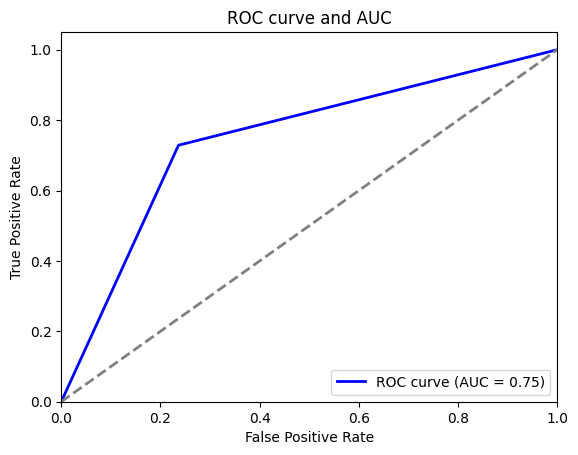

In [260]:
from sklearn.linear_model import LogisticRegression

# Instanciar clasificador de SKlearn
log_reg = LogisticRegression()

# Definir parámetros
param_grid = {
    'max_iter': [5, 50, 500, 750]
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(X_train_wines, y_train_wines)

print("Los mejores parámetros son: ", grid_search.best_params_)

# Obtener el mejor clasificador
best_log_reg = grid_search.best_estimator_

# Predecir para conjunto de training
y_pred_wines_train = best_log_reg.predict(X_train_wines)
# Predecir para conjunto de testing
y_pred_wines_test = best_log_reg.predict(X_test_wines)

accuracy = best_log_reg.score(X_test_wines, y_test_wines)
print(f'Precisión del algoritmo: {accuracy:.2f}')

print("Resultados para el conjunto de training")
display(computeSklearnMetrics(y_train_wines, y_pred_wines_train))

print("Resultados para el conjunto de testing")
computeSklearnMetrics(y_test_wines, y_pred_wines_test)

### Regresión Logística Notas de Arquitectura de Computadores 1 Sklearn

Los mejores parámetros son:  {'max_iter': 50}
Precisión del algoritmo: 0.94
Resultados para el conjunto de training


/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

,Accuracy,Precision,Recall,F1 Score,AUC
0,0.911765,0.931034,0.964286,0.947368,0.815476


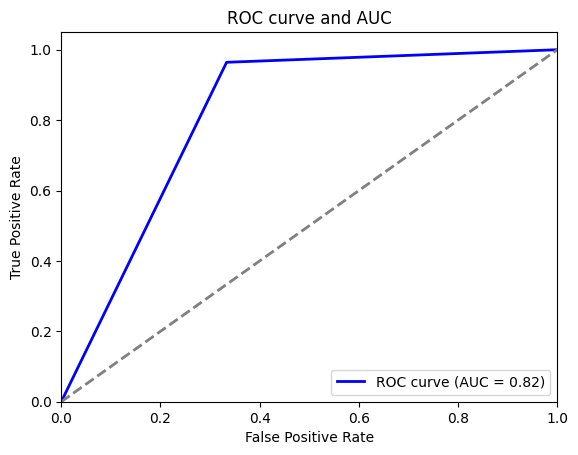

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.944444,0.9375,1.0,0.967742,0.833333


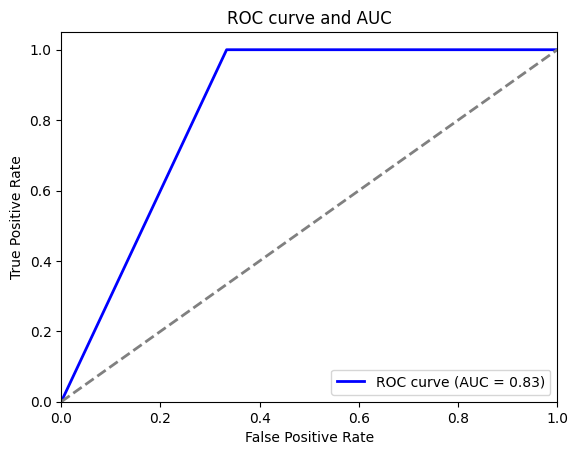

In [261]:
# Instanciar clasificador de SKlearn
log_reg = LogisticRegression()

# Definir parámetros
param_grid = {
    'max_iter': [5, 50, 500, 750]
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(X_train_arqui, y_train_arqui)

print("Los mejores parámetros son: ", grid_search.best_params_)

# Obtener el mejor clasificador
best_log_reg = grid_search.best_estimator_

# Predecir para conjunto de training
y_pred_arqui_train = best_log_reg.predict(X_train_arqui)
# Predecir para conjunto de testing
y_pred_arqui_test = best_log_reg.predict(X_test_arqui)

accuracy = best_log_reg.score(X_test_arqui, y_test_arqui)
print(f'Precisión del algoritmo: {accuracy:.2f}')

print("Resultados para el conjunto de training")
display(computeSklearnMetrics(y_train_arqui, y_pred_arqui_train))

print("Resultados para el conjunto de testing")
computeSklearnMetrics(y_test_arqui, y_pred_arqui_test)

### Regresión Logística Propio Sklearn

Los mejores parámetros son:  {'max_iter': 5}
Precisión del algoritmo: 0.91
Resultados para el conjunto de training


/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

,Accuracy,Precision,Recall,F1 Score,AUC
0,0.824176,0.823009,0.885714,0.853211,0.812987


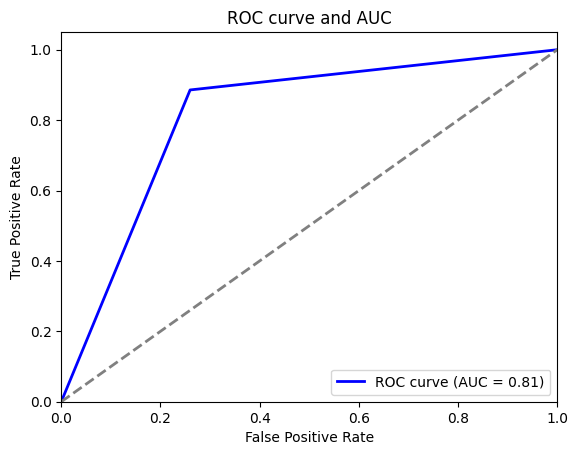

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.913043,0.96,0.888889,0.923077,0.918129


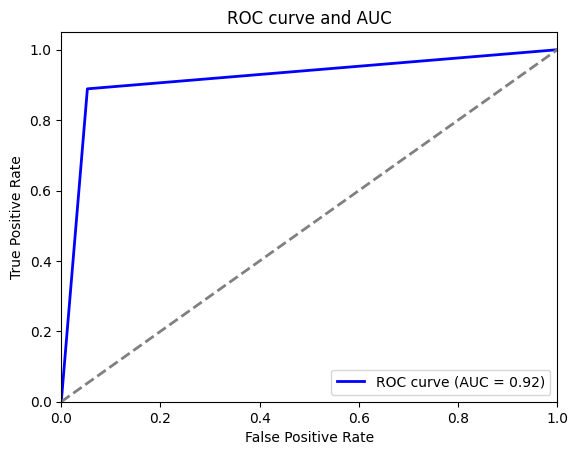

In [262]:
# Instanciar clasificador de SKlearn
log_reg = LogisticRegression()

# Definir parámetros
param_grid = {
    'max_iter': [5, 50, 500, 750]
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(X_train_heart, y_train_heart)

print("Los mejores parámetros son: ", grid_search.best_params_)

# Obtener el mejor clasificador
best_log_reg = grid_search.best_estimator_

# Predecir para conjunto de training
y_pred_heart_train = best_log_reg.predict(X_train_heart)
# Predecir para conjunto de testing
y_pred_heart_test = best_log_reg.predict(X_test_heart)

accuracy = best_log_reg.score(X_test_heart, y_test_heart)
print(f'Precisión del algoritmo: {accuracy:.2f}')

print("Resultados para el conjunto de training")
display(computeSklearnMetrics(y_train_heart, y_pred_heart_train))

print("Resultados para el conjunto de testing")
computeSklearnMetrics(y_test_heart, y_pred_heart_test)

### Árboles de decisión Red Wine Quality

Los mejores parámetros son:  {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}
Precisión del algoritmo: 0.74
Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


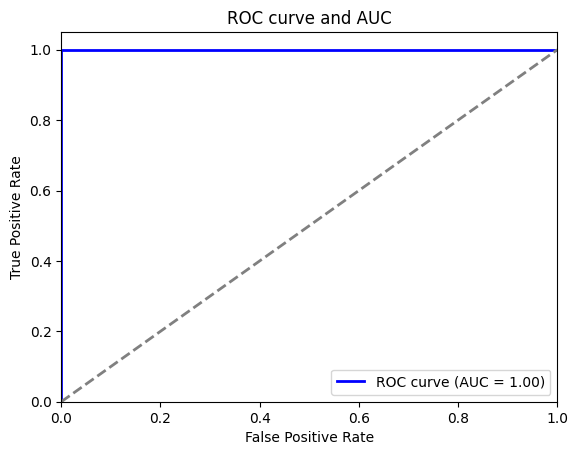

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.740586,0.768,0.744186,0.755906,0.740275


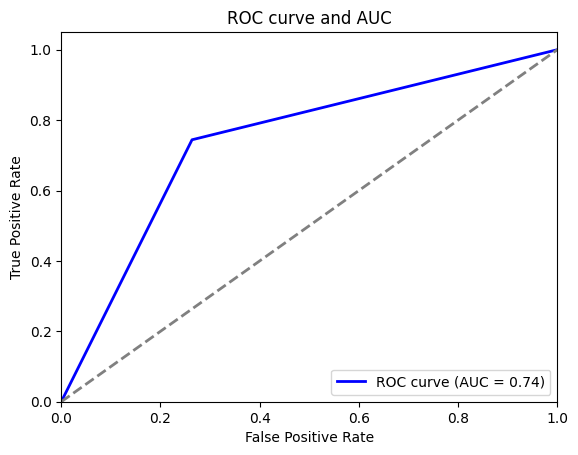

In [263]:
from sklearn.tree import DecisionTreeClassifier

# Instanciar clasificador de SKlearn
tree = DecisionTreeClassifier()

# Definir parámetros
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, 12, 14],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train_wines, y_train_wines)

print("Los mejores parámetros son: ", grid_search.best_params_)

# Obtener el mejor clasificador
best_tree = grid_search.best_estimator_

# Predecir para conjunto de training
y_pred_wines_train = best_tree.predict(X_train_wines)
# Predecir para conjunto de testing
y_pred_wines_test = best_tree.predict(X_test_wines)

accuracy = best_tree.score(X_test_wines, y_test_wines)
print(f'Precisión del algoritmo: {accuracy:.2f}')

print("Resultados para el conjunto de training")
display(computeSklearnMetrics(y_train_wines, y_pred_wines_train))

print("Resultados para el conjunto de testing")
computeSklearnMetrics(y_test_wines, y_pred_wines_test)

### Árboles de decisión Notas de Arquitectura de Computadores 1 Sklearn

Los mejores parámetros son:  {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}
Precisión del algoritmo: 0.89
Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.985294,0.982456,1.0,0.99115,0.958333


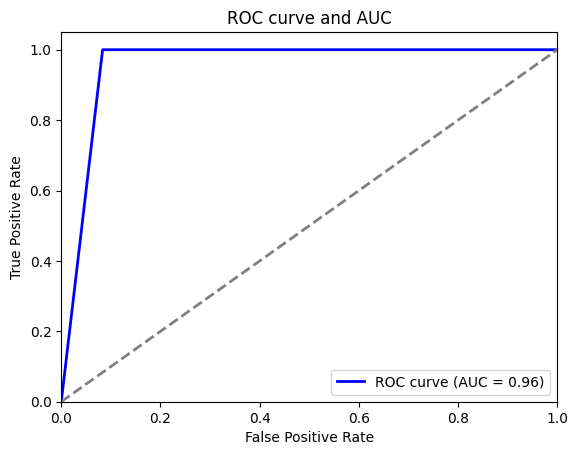

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.888889,0.933333,0.933333,0.933333,0.8


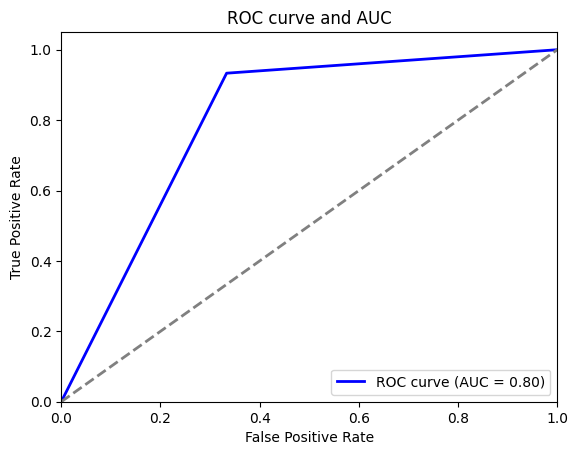

In [264]:
# Instanciar clasificador de SKlearn
tree = DecisionTreeClassifier()

# Definir parámetros
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, 12, 14],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train_arqui, y_train_arqui)

print("Los mejores parámetros son: ", grid_search.best_params_)

# Obtener el mejor clasificador
best_tree = grid_search.best_estimator_

# Predecir para conjunto de training
y_pred_arqui_train = best_tree.predict(X_train_arqui)
# Predecir para conjunto de testing
y_pred_arqui_test = best_tree.predict(X_test_arqui)

accuracy = best_tree.score(X_test_arqui, y_test_arqui)
print(f'Precisión del algoritmo: {accuracy:.2f}')

print("Resultados para el conjunto de training")
display(computeSklearnMetrics(y_train_arqui, y_pred_arqui_train))

print("Resultados para el conjunto de testing")
computeSklearnMetrics(y_test_arqui, y_pred_arqui_test)

### Árboles de decisión Propio Sklearn

Los mejores parámetros son:  {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}
Precisión del algoritmo: 0.78
Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.884615,0.903846,0.895238,0.899522,0.882684


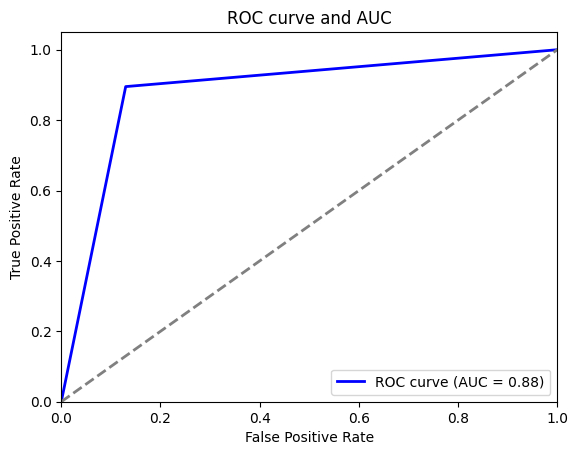

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.782609,0.814815,0.814815,0.814815,0.775828


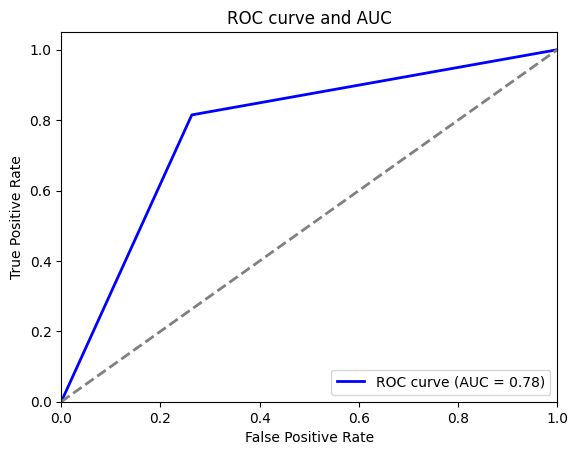

In [265]:
# Instanciar clasificador de SKlearn
tree = DecisionTreeClassifier()

# Definir parámetros
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, 12, 14],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train_heart, y_train_heart)

print("Los mejores parámetros son: ", grid_search.best_params_)

# Obtener el mejor clasificador
best_tree = grid_search.best_estimator_

# Predecir para conjunto de training
y_pred_heart_train = best_tree.predict(X_train_heart)
# Predecir para conjunto de testing
y_pred_heart_test = best_tree.predict(X_test_heart)

accuracy = best_tree.score(X_test_heart, y_test_heart)
print(f'Precisión del algoritmo: {accuracy:.2f}')

print("Resultados para el conjunto de training")
display(computeSklearnMetrics(y_train_heart, y_pred_heart_train))

print("Resultados para el conjunto de testing")
computeSklearnMetrics(y_test_heart, y_pred_heart_test)

### KNN Red Wine Quality Sklearn

Los mejores parámetros son:  {'n_neighbors': 17, 'weights': 'distance'}
Precisión del algoritmo: 0.79
Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


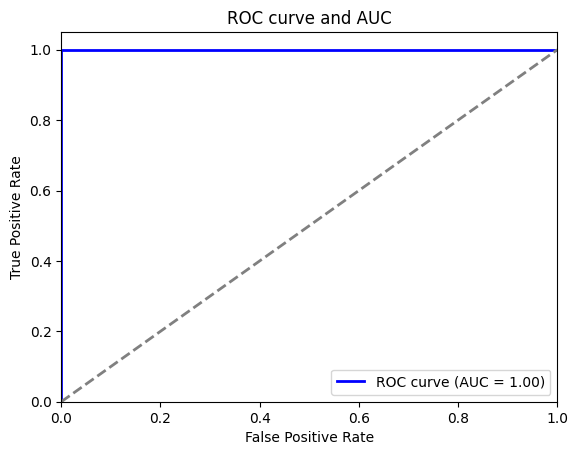

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.794979,0.822581,0.790698,0.806324,0.795349


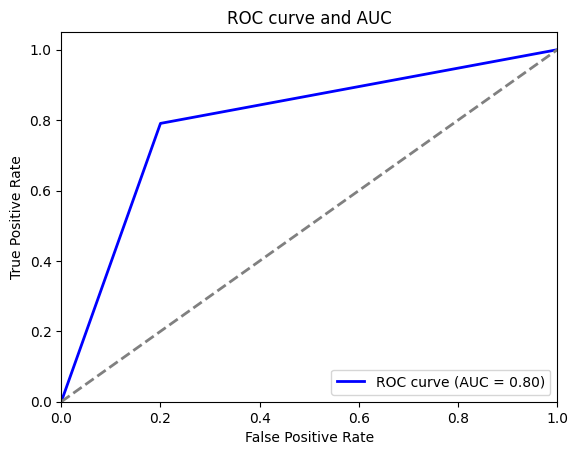

In [266]:
from sklearn.neighbors import KNeighborsClassifier

# Instanciar clasificador de SKlearn
knn = KNeighborsClassifier()

# Definir parámetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35],
    'weights': ['uniform', 'distance']
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_wines, y_train_wines)

print("Los mejores parámetros son: ", grid_search.best_params_)

# Obtener el mejor clasificador
best_knn = grid_search.best_estimator_

# Predecir para conjunto de training
y_pred_wines_train = best_knn.predict(X_train_wines)
# Predecir para conjunto de testing
y_pred_wines_test = best_knn.predict(X_test_wines)

accuracy = best_knn.score(X_test_wines, y_test_wines)
print(f'Precisión del algoritmo: {accuracy:.2f}')

print("Resultados para el conjunto de training")
display(computeSklearnMetrics(y_train_wines, y_pred_wines_train))

print("Resultados para el conjunto de testing")
computeSklearnMetrics(y_test_wines, y_pred_wines_test)

### KNN Notas de Arquitectura de Computadores 1 Sklearn

Los mejores parámetros son:  {'n_neighbors': 3, 'weights': 'uniform'}
Precisión del algoritmo: 1.00
Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.926471,0.932203,0.982143,0.956522,0.824405


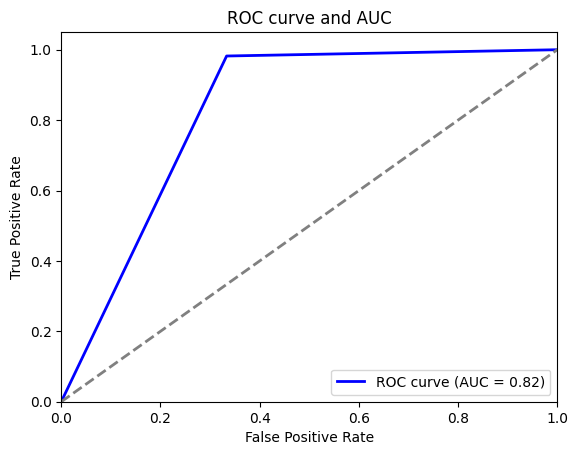

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


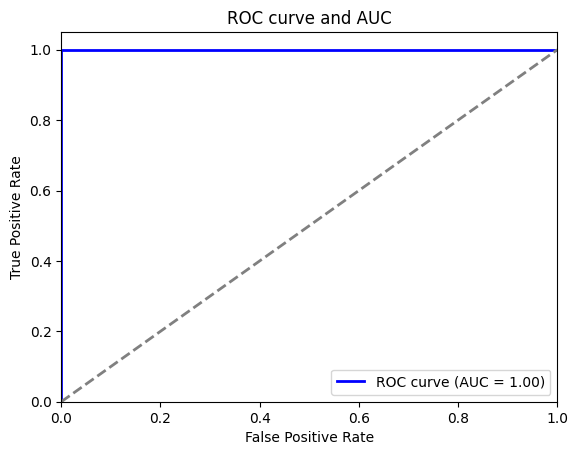

In [267]:
# Instanciar clasificador de SKlearn
knn = KNeighborsClassifier()

# Definir parámetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35],
    'weights': ['uniform', 'distance']
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_arqui, y_train_arqui)

print("Los mejores parámetros son: ", grid_search.best_params_)

# Obtener el mejor clasificador
best_knn = grid_search.best_estimator_

# Predecir para conjunto de training
y_pred_arqui_train = best_knn.predict(X_train_arqui)
# Predecir para conjunto de testing
y_pred_arqui_test = best_knn.predict(X_test_arqui)

accuracy = best_knn.score(X_test_arqui, y_test_arqui)
print(f'Precisión del algoritmo: {accuracy:.2f}')

print("Resultados para el conjunto de training")
display(computeSklearnMetrics(y_train_arqui, y_pred_arqui_train))

print("Resultados para el conjunto de testing")
computeSklearnMetrics(y_test_arqui, y_pred_arqui_test)

### KNN Propio Sklearn

Los mejores parámetros son:  {'n_neighbors': 19, 'weights': 'distance'}
Precisión del algoritmo: 0.89
Resultados para el conjunto de training


,Accuracy,Precision,Recall,F1 Score,AUC
0,1.0,1.0,1.0,1.0,1.0


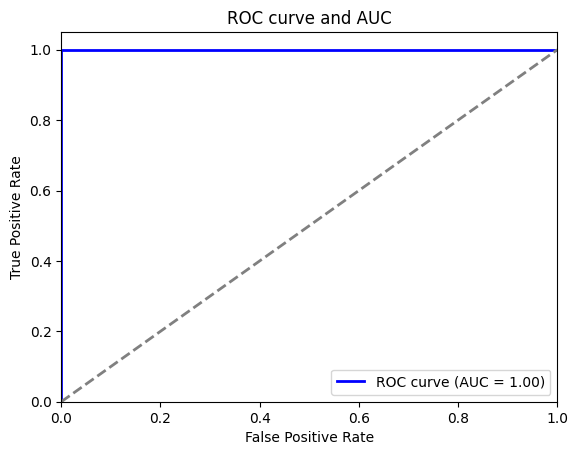

None

Resultados para el conjunto de testing


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.891304,0.923077,0.888889,0.90566,0.891813


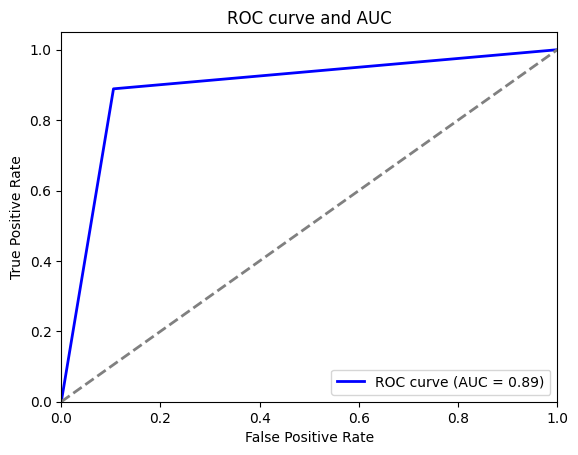

In [268]:
# Instanciar clasificador de SKlearn
knn = KNeighborsClassifier()

# Definir parámetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35],
    'weights': ['uniform', 'distance']
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_heart, y_train_heart)

print("Los mejores parámetros son: ", grid_search.best_params_)

# Obtener el mejor clasificador
best_knn = grid_search.best_estimator_

# Predecir para conjunto de training
y_pred_heart_train = best_knn.predict(X_train_heart)
# Predecir para conjunto de testing
y_pred_heart_test = best_knn.predict(X_test_heart)

accuracy = best_knn.score(X_test_heart, y_test_heart)
print(f'Precisión del algoritmo: {accuracy:.2f}')

print("Resultados para el conjunto de training")
display(computeSklearnMetrics(y_train_heart, y_pred_heart_train))

print("Resultados para el conjunto de testing")
computeSklearnMetrics(y_test_heart, y_pred_heart_test)

## Tabla Comparativa

In [271]:
print("Comparación de datos y algoritmos")
metrics_data = {
  "Accuracy": accuracy_data_,
  "Precision": precision_data,
  "Recall": recall_data,
  "F1": f1_data,
  "AUC": auc_data
}
metrics_sklearn = {  
  "Accuracy_sklearn": accuracy_sklearn,
  "Precision_sklearn": precision_sklearn,
  "Recall_sklearn": recall_sklearn,
  "F1_sklearn": f1_sklearn,
  "AUC_sklearn": auc_sklearn
}

index_ = ["Regresión Logística: Red wine Quality (Train)", 
  "Regresión Logística: Red wine Quality (Test)", "Regresión Logística: Notas Arqui (Train)",
  "Regresión Logística: Notas Arqui (Test)", "Regresión Logística: Propio (Train)",
  "Regresión Logística: Propio (Test)", "Árboles de decisión: Red wine Quality (Train)",
  "Árboles de decisión: Red wine Quality (Test)", "Árboles de decisión: Notas Arqui (Train)",
  "Árboles de decisión: Notas Arqui (Test)", "Árboles de decisión: Propio (Train)", 
  "Árboles de decisión: Propio (Test)", "KNN: Red wine Quality (Train)", 
  "KNN: Red wine Quality (Test)", "KNN: Notas Arqui (Train)",
  "KNN: Notas Arqui (Test)", "KNN: Propio (Train)", "KNN: Propio (Test)"]

metrics = pd.DataFrame( metrics_data,index = index_)

display(metrics)

metrics_sk = pd.DataFrame( metrics_sklearn,index = index_)

display(metrics_sk)

Comparación de datos y algoritmos


,Accuracy,Precision,Recall,F1,AUC
Regresión Logística: Red wine Quality (Train),0.741361,0.769539,0.744186,0.756650,0.741114
Regresión Logística: Red wine Quality (Test),0.753138,0.791667,0.736434,0.763052,0.754581
Regresión Logística: Notas Arqui (Train),0.926471,0.932203,0.982143,0.956522,0.824405
Regresión Logística: Notas Arqui (Test),0.944444,0.937500,1.000000,0.967742,0.833333
Regresión Logística: Propio (Train),0.851648,0.848214,0.904762,0.875576,0.841991
Regresión Logística: Propio (Test),0.913043,0.960000,0.888889,0.923077,0.918129
Árboles de decisión: Red wine Quality (Train),1.000000,1.000000,1.000000,1.000000,1.000000
Árboles de decisión: Red wine Quality (Test),1.000000,1.000000,1.000000,1.000000,1.000000
Árboles de decisión: Notas Arqui (Train),1.000000,1.000000,1.000000,1.000000,1.000000
Árboles de decisión: Notas Arqui (Test),1.000000,1.000000,1.000000,1.000000,1.000000


,Accuracy_sklearn,Precision_sklearn,Recall_sklearn,F1_sklearn,AUC_sklearn
Regresión Logística: Red wine Quality (Train),0.740314,0.768000,0.744186,0.755906,0.739975
Regresión Logística: Red wine Quality (Test),0.744770,0.783333,0.728682,0.755020,0.746159
Regresión Logística: Notas Arqui (Train),0.911765,0.931034,0.964286,0.947368,0.815476
Regresión Logística: Notas Arqui (Test),0.944444,0.937500,1.000000,0.967742,0.833333
Regresión Logística: Propio (Train),0.824176,0.823009,0.885714,0.853211,0.812987
Regresión Logística: Propio (Test),0.913043,0.960000,0.888889,0.923077,0.918129
Árboles de decisión: Red wine Quality (Train),1.000000,1.000000,1.000000,1.000000,1.000000
Árboles de decisión: Red wine Quality (Test),0.740586,0.768000,0.744186,0.755906,0.740275
Árboles de decisión: Notas Arqui (Train),0.985294,0.982456,1.000000,0.991150,0.958333
Árboles de decisión: Notas Arqui (Test),0.888889,0.933333,0.933333,0.933333,0.800000


## Puntos Extra

In [272]:
class Linear_Regression:
    def __init__(self, learning_rate=0.005, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape

        # Inicializar W y b
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Optimización 
        for _ in range(self.num_iterations):
            y_pred = np.dot(X, self.weights) + self.bias

            # Cálculo de los gradientes (derivadas)
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Actualizar los pesos y b
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


In [273]:
# Cargar los datos de Arqui_extratectura 1
data_arqui_extra_2021_s1 = pd.read_csv("2021-s1.csv", delimiter=';')
data_arqui_extra_2021_s2 = pd.read_csv("2021-s2.csv", delimiter=';')
data_arqui_extra_2022_s1 = pd.read_csv("2022-s1.csv", delimiter=';')
data_arqui_extra_2022_s2 = pd.read_csv("2022-s2.csv", delimiter=';')

#=======  Feature Engineering  =======#

# Feature Selection
# Conservar solo features que se toman en cuenta de cada archivo
data_arqui_extra_2021_s1 = data_arqui_extra_2021_s1.loc[:, ['Examen 1 15.0%', 'Taller 1',
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Funcional 13.12%', 'Total: ']]
data_arqui_extra_2021_s2 = data_arqui_extra_2021_s2.loc[:, ['Examen 1 15.0%', 'Taller 1', 
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Funcional 13.12%', 'Total: ']]
data_arqui_extra_2022_s1 = data_arqui_extra_2022_s1.loc[:, ['Examen parcial 1 15%', 'Taller 1',
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Funcional 13.12%', 'Total: ']]
data_arqui_extra_2022_s2 = data_arqui_extra_2022_s2.loc[:, ['Examen parcial 1 15%', 'Taller 1 1.87%',
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Func Eval 13.12%', 'Total: ']]

# Renombrar columnas para combinarlas
data_arqui_extra_2021_s1 = data_arqui_extra_2021_s1.rename(columns={'Examen parcial 1 15%': 'Examen 1 15.0%'})
data_arqui_extra_2022_s1 = data_arqui_extra_2022_s1.rename(columns={'Examen parcial 1 15%': 'Examen 1 15.0%'})
data_arqui_extra_2022_s2 = data_arqui_extra_2022_s2.rename(columns={'Examen parcial 1 15%': 'Examen 1 15.0%', 
                            'Proyecto Grupal 1 Func Eval 13.12%': 'Proyecto Grupal 1 Funcional 13.12%',
                            'Taller 1 1.87%': 'Taller 1'})

# Combinar todos los datos en un solo set
data_arqui_extra_combined = pd.concat([data_arqui_extra_2021_s1, data_arqui_extra_2021_s2,
                                  data_arqui_extra_2022_s1, data_arqui_extra_2022_s2], 
                                  axis=0, ignore_index=True)

# Reemplazar espacios en blanco con NaN
data_arqui_extra_combined = data_arqui_extra_combined.replace(' ', np.nan)
# Eliminar filas que contengan al menos un NaN
data_arqui_extra_combined = data_arqui_extra_combined.dropna()
# Castear tipos de string a float
data_arqui_extra_combined = data_arqui_extra_combined.astype('float64')

# Ajustar pesos
data_arqui_extra_combined['Examen 1 15.0%'] = data_arqui_extra_combined['Examen 1 15.0%']*0.15
data_arqui_extra_combined['Taller 1'] = data_arqui_extra_combined['Taller 1']*0.015
data_arqui_extra_combined['Proyecto Individual Funcional 11.25%'] = data_arqui_extra_combined['Proyecto Individual Funcional 11.25%']*0.1125
data_arqui_extra_combined['Proyecto Grupal 1 Funcional 13.12%'] = data_arqui_extra_combined['Proyecto Grupal 1 Funcional 13.12%']*0.1312

X = data_arqui_extra_combined.drop('Total: ', axis=1)
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = MinMaxScaler()
scaler.fit(X[numeric_cols])
scaled_data = scaler.transform(X[numeric_cols])
data_arqui_extra_combined[numeric_cols] = scaled_data

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_arqui_extra, X_test_arqui_extra, y_train_arqui_extra, y_test_arqui_extra = train_test_split(data_arqui_extra_combined.drop('Total: ', axis=1), 
    data_arqui_extra_combined['Total: '], test_size=0.2, random_state=15)#stratify=data_arqui_extra_combined['Total: '])
#15
X_train_arqui_extra = X_train_arqui_extra.values
X_test_arqui_extra  = X_test_arqui_extra.values
y_train_arqui_extra = y_train_arqui_extra.values
y_test_arqui_extra  = y_test_arqui_extra.values

data_arqui_extra_combined.head(3)

,Examen 1 15.0%,Taller 1,Proyecto Individual Funcional 11.25%,Proyecto Grupal 1 Funcional 13.12%,Total:
0,0.571613,0.8,1.0,1.00,80.2
2,0.523871,1.0,1.0,0.45,80.8
4,0.678710,1.0,1.0,1.00,82.1


In [274]:
#Instanciar Regresión Lineal de Numpy

# Create and fit the custom linear regression model
model = Linear_Regression()
model.fit(X_train_arqui_extra, y_train_arqui_extra)

# Predict target values for new input
predicted_y = model.predict(X_test_arqui_extra)

comparisson = {
  "Notas esperadas": y_test_arqui_extra[:20],
  "Notas predichas": predicted_y[:20]
}
comp = pd.DataFrame(comparisson, index = list(range(19)))
display(comp)


def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mse = mean_squared_error(y_test_arqui_extra, predicted_y)
print('MSE de la predicción: ', mse)

#Bajar el learning rate

,Notas esperadas,Notas predichas
0,70.08,64.362009
1,88.17,91.039615
2,67.94,59.705608
3,76.16,73.313171
4,73.41,82.034184
5,83.63,75.892441
6,77.60,84.878215
7,50.20,50.995912
8,75.20,76.480774
9,79.32,74.876613


MSE de la predicción:  24.674600727891992
